# Train and evaluate Explainers

With all these prerequisites out of the way you can now run the experiments themselves. The experiments are run for each
explanation method (T-GNNExplainer, GreDyCF, CoDy), for each dataset, for each correct/incorrect setting 
(correct predictions only/incorrect predictions only), and for each selection policy (random, temporal, spatio-temporal, 
local-gradient) separately. For convenience, all selection strategies can be automatically evaluated in parallel from a 
single script. An additional feature of the evaluation is that it can be interrupted by Keyboard Interruption or by the
maximum processing time. When the evaluation is interrupted before it is finished, the intermediary results are saved. 
The evaluation automatically resumes from intermediary results.

In [1]:
# Find and add `notebooks/src` to sys.path, no matter where the notebook lives.
from pathlib import Path
import json
import sys, importlib
import os, re
import torch
from collections import defaultdict
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def _add_notebooks_src_to_path():
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        candidate = p / "notebooks" / "src"
        if candidate.is_dir():
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    raise FileNotFoundError("Could not find 'notebooks/src' from current working directory.")

print("Using helpers from:", _add_notebooks_src_to_path())

from constants import (
    REPO_ROOT, PKG_DIR, RESOURCES_DIR, PROCESSED_DATA_DIR, MODELS_ROOT, TGN_SUBMODULE_ROOT, ensure_repo_importable, get_last_checkpoint,
    load_notebook_config,
)
ensure_repo_importable()
from device import pick_device
NOTEBOOK_CFG = load_notebook_config()
SEED = int(NOTEBOOK_CFG.get("seed", 42))
DEVICE = pick_device(NOTEBOOK_CFG.get("device", "auto"))
print(f"Notebook config: seed={SEED}, device={DEVICE}")

if "DEVICE" not in globals():
    import torch
    try:
        from device import pick_device
        DEVICE = pick_device(NOTEBOOK_CFG.get("device", "auto") if "NOTEBOOK_CFG" in globals() else "auto")
    except Exception:
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", DEVICE)
for p in (str(TGN_SUBMODULE_ROOT), str(REPO_ROOT), str(PKG_DIR)):
    if p not in sys.path:
        sys.path.insert(0, p)

# 2) If your notebook already imported `utils`, remove it to avoid collision
if "utils" in sys.modules:
    del sys.modules["utils"]

importlib.invalidate_caches()

# 4) (Optional) sanity check that TGN's local packages resolve
import importlib.util as iu
print("utils.utils   ->", iu.find_spec("utils.utils"))
print("modules.memory->", iu.find_spec("modules.memory"))


print("REPO_ROOT        :", REPO_ROOT)
print("PKG_DIR          :", PKG_DIR)
print("RESOURCES_DIR    :", RESOURCES_DIR)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)
print("MODELS_ROOT      :", MODELS_ROOT)


Using helpers from: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/notebooks/src
Notebook config: seed=42, device=mps
utils.utils   -> None
modules.memory-> ModuleSpec(name='modules.memory', loader=<_frozen_importlib_external.SourceFileLoader object at 0x106da3950>, origin='/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/submodules/models/tgn/modules/memory.py')
REPO_ROOT        : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
PKG_DIR          : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain
RESOURCES_DIR    : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources
PROCESSED_DATA_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/datasets/processed
MODELS_ROOT      : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models


## Imports

In [2]:
from time_to_explain.utils.graph import NeighborFinder
# Core imports
from time_to_explain.data.legacy.tg_dataset import load_explain_idx
from time_to_explain.data.workflows import load_processed_dataset_safe
from submodules.models.tgat.module import TGAN
from submodules.models.tgn.model.tgn import TGN
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.models.ext.tgn.utils.data_processing import compute_time_statistics

from time_to_explain.core.runner import EvaluationRunner, EvalConfig
from time_to_explain.metrics.eval_config import METRICS_CFG

from time_to_explain.adapters import *
from time_to_explain.extractors.base_extractor import BaseExtractor
from time_to_explain.visualization import (
    default_curve_specs,
    plot_explainer_metric_summary,
    plot_explainer_runtime,
    prepare_metrics_plotting,
    plot_metric_curves,
    plot_prediction_match_rate,
    summarize_curve_results,
)
from time_to_explain.explainer.shap import ShapAdapterConfig, ShapExplainer
from time_to_explain.explainer.gradient import GradientAdapterConfig, GradientExplainer
from time_to_explain.explainer.tempme import TempMEAdapter, TempMEAdapterConfig


Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain


## Config

In [3]:
MODEL_TYPE = "tgn"
DATASET_NAME = "stick_figure"
TIME_LIMIT = 240

N = 8
USE_CACHED_RESULTS = False

## Load Dataset and Model

In [4]:
def _find_checkpoint(models_root: Path, dataset_name: str, model_name: str) -> Path:
    model_name = model_name.lower()
    dataset_name = str(dataset_name)
    candidates = [
        models_root / dataset_name / model_name / f"{model_name}_{dataset_name}_best.pth",
        models_root / dataset_name / "checkpoints" / f"{model_name}_{dataset_name}_best.pth",
        models_root / "checkpoints" / f"{model_name}_{dataset_name}_best.pth",
    ]
    for cand in candidates:
        if cand.exists():
            return cand
    search_roots = [
        models_root / dataset_name / model_name,
        models_root / dataset_name,
        models_root / "checkpoints",
        models_root / "runs",
    ]
    for root in search_roots:
        if not root.exists():
            continue
        matches = sorted(root.rglob(f"{model_name}*{dataset_name}*.pth"))
        if not matches:
            matches = sorted(root.rglob("*.pth"))
        for match in matches:
            if "best" in match.name:
                return match
        if matches:
            return matches[0]
    raise FileNotFoundError(
        f"Checkpoint not found under {models_root} for {model_name}_{dataset_name}."
    )

ckpt_path = _find_checkpoint(MODELS_ROOT, DATASET_NAME, MODEL_TYPE)
print("Using checkpoint:", ckpt_path)
explain_idx_csv = str(RESOURCES_DIR / "explainer" / "explain_index" / f"{DATASET_NAME}.csv")
print("Explain index CSV:", explain_idx_csv)

Using checkpoint: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models/stick_figure/checkpoints/tgn_stick_figure_best.pth
Explain index CSV: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/explain_index/stick_figure.csv


In [5]:
# Refine fidelity sparsity levels (denser between 0.00 and 0.05)
import numpy as np
low_levels = [round(float(x), 4) for x in np.linspace(0.0, 0.05, 11)]
rest_levels = [round(float(x), 4) for x in np.arange(0.06, 0.3001, 0.02)]
fid_levels = sorted(set(low_levels + rest_levels))
METRICS_CFG['fidelity_keep']['sparsity_levels'] = fid_levels
if 'temgx_fidelity_minus' in METRICS_CFG:
    METRICS_CFG['temgx_fidelity_minus']['sparsity_levels'] = fid_levels
if 'temgx_fidelity_plus' in METRICS_CFG:
    METRICS_CFG['temgx_fidelity_plus']['sparsity_levels'] = fid_levels
if 'singular_value' in METRICS_CFG:
    METRICS_CFG['singular_value']['sparsity_levels'] = fid_levels


In [6]:
# Load data
try:
    bundle = load_processed_dataset_safe(DATASET_NAME, verbose=True)
except FileNotFoundError as exc:
    raise FileNotFoundError(
        f"Processed dataset {DATASET_NAME!r} not found. "
        "Run notebooks/00_prepare_datasets.ipynb for this dataset."
    ) from exc
events = bundle["interactions"]
edge_feats = bundle.get("edge_features")
node_feats = bundle.get("node_features")
metadata = bundle.get("metadata") or {}
config_meta = metadata.get("config") if isinstance(metadata.get("config"), dict) else {}
def _infer_bipartite_from_events(df: pd.DataFrame) -> bool:
    if len(df) == 0:
        return False
    u_min, u_max = int(df["u"].min()), int(df["u"].max())
    i_min, i_max = int(df["i"].min()), int(df["i"].max())
    return i_min > u_max or u_min > i_max

is_bipartite = metadata.get("bipartite", config_meta.get("bipartite"))
if is_bipartite is None:
    is_bipartite = _infer_bipartite_from_events(events)
else:
    is_bipartite = bool(is_bipartite)
if DATASET_NAME in {"stick_figure", "sticky_hips"}:
    is_bipartite = False

def _build_neighbor_finder(df: pd.DataFrame) -> NeighborFinder:
    u = df["u"].to_numpy(dtype=int)
    v = df["i"].to_numpy(dtype=int)
    ts = df["ts"].to_numpy(dtype=float)
    if "e_idx" in df.columns:
        e_idx = df["e_idx"].to_numpy(dtype=int)
    elif "idx" in df.columns:
        e_idx = df["idx"].to_numpy(dtype=int)
    else:
        e_idx = np.arange(1, len(df) + 1, dtype=int)
    max_node = int(max(u.max(), v.max())) if len(df) else 0
    adj_list = [[] for _ in range(max_node + 1)]
    for src, dst, t, e in zip(u, v, ts, e_idx):
        adj_list[int(src)].append((int(dst), int(e), float(t)))
        adj_list[int(dst)].append((int(src), int(e), float(t)))
    return NeighborFinder(adj_list, uniform=False)

configs_dir = REPO_ROOT / "configs" / "models"
config_candidates = [
    configs_dir / f"compare_{MODEL_TYPE.lower()}_{DATASET_NAME}.json",
    configs_dir / f"compare_{MODEL_TYPE.lower()}.json",
    configs_dir / f"infer_{MODEL_TYPE.lower()}_{DATASET_NAME}.json",
    configs_dir / f"infer_{MODEL_TYPE.lower()}.json",
]
model_config_path = next((p for p in config_candidates if p.exists()), None)
if model_config_path is None:
    raise FileNotFoundError(
        "Model config not found. Expected one of: "
        + ", ".join(str(p) for p in config_candidates)
    )
model_config = json.loads(model_config_path.read_text())
config_model = str(model_config.get("model", "")).lower()
if config_model and config_model != MODEL_TYPE.lower():
    raise ValueError(
        f"Config model {config_model!r} does not match MODEL_TYPE={MODEL_TYPE!r}"
    )
model_args = dict(model_config.get("args") or {})
print(f"Using model config: {model_config_path}")

# Build the backbone model
if MODEL_TYPE == "tgat":
    if not is_bipartite:
        raise ValueError("TGAT expects bipartite datasets; set MODEL_TYPE='tgn' for stick_figure.")
    ngh_finder = _build_neighbor_finder(events)
    backbone = TGAN(
        ngh_finder,
        node_feats,
        edge_feats,
        device=DEVICE,
        **model_args,
    )
elif MODEL_TYPE == "tgn":
    m_src, s_src, m_dst, s_dst = compute_time_statistics(events.u.values, events.i.values, events.ts.values)
    ngh_finder = _build_neighbor_finder(events)   # your utils often reuse the same NF
    backbone = TGN(
        ngh_finder,
        node_feats,
        edge_feats,
        device=DEVICE,
        mean_time_shift_src=m_src,
        std_time_shift_src=s_src,
        mean_time_shift_dst=m_dst,
        std_time_shift_dst=s_dst,
        **model_args,
    )
else:
    raise NotImplementedError(MODEL_TYPE)

# Load backbone weights
state_dict = torch.load(ckpt_path, map_location="cpu")
_ = backbone.load_state_dict(state_dict, strict=False)
_ = backbone.to(DEVICE).eval()
print("Backbone ready on", DEVICE)
# Wrap backbone with ModelProtocol adapter (adds predict_proba & masking)
model = TemporalGNNModelAdapter(backbone, events, device=DEVICE)


Loaded flat processed files for 'stick_figure'.
Using model config: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/models/infer_tgn.json
Backbone ready on mps


/var/folders/k7/xf0yhfbs02ggfm7n1l5g_cnm0000gn/T/ipykernel_71548/3652151995.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_locat

## Build Extractor and Explainer

### Build Extractor

In [7]:
# Extractors: main for mask-based explainers (reused for TempME so fidelity masks align)
extractor_main = BaseExtractor(
    model=model,
    events=events,
    threshold_num=5000,
    keep_order="last-N-then-sort",
)

<hr style="height:1px;border:none;background:#ccc;">


### Build Explainer

In [8]:
# Explainer config loader
CONFIGS_DIR = REPO_ROOT / "configs" / "explainer"


def _format_value(val):
    if isinstance(val, str):
        lowered = val.lower()
        if lowered in {"inf", "infinity"}:
            return float("inf")
        try:
            return val.format(model_type=MODEL_TYPE, dataset_name=DATASET_NAME)
        except Exception:
            return val
    if isinstance(val, dict):
        return {k: _format_value(v) for k, v in val.items()}
    if isinstance(val, list):
        return [_format_value(v) for v in val]
    return val


def _resolve_path(value: str) -> str:
    path = Path(value).expanduser()
    if not path.is_absolute():
        path = REPO_ROOT / path
    return str(path)


def load_explainer_config(name: str, *, allow_missing: bool = False):
    candidates = [
        CONFIGS_DIR / f"{name.lower()}_{DATASET_NAME}.json",
        CONFIGS_DIR / f"{name.lower()}.json",
    ]
    config_path = next((p for p in candidates if p.exists()), None)
    if config_path is None:
        if allow_missing:
            return None, None, None
        raise FileNotFoundError(
            "Explainer config not found. Expected one of: "
            + ", ".join(str(p) for p in candidates)
        )
    config = json.loads(config_path.read_text(encoding="utf-8"))
    adapter = config.get("adapter") or config.get("name") or name
    args = _format_value(dict(config.get("args") or {}))
    for key in ("results_dir", "mcts_saved_dir", "explainer_ckpt_dir", "explainer_ckpt"):
        if key in args and args[key]:
            args[key] = _resolve_path(str(args[key]))
    nav_params = args.get("navigator_params")
    if isinstance(nav_params, dict) and nav_params.get("explainer_ckpt_dir"):
        nav_params["explainer_ckpt_dir"] = _resolve_path(str(nav_params["explainer_ckpt_dir"]))
    return adapter, args, config_path


EXPLAINER_BUILDERS = {
    "subgraphx_tg": (SubgraphXTGAdapterConfig, SubgraphXTGAdapter),
    "tempme": (TempMEAdapterConfig, TempMEAdapter),
    "pg": (PGAdapterConfig, PGAdapter),
    "gnn": (GNNExplainerAdapterConfig, GNNExplainerAdapter),
    "perturb_one": (PerturbOneAdapterConfig, PerturbOneAdapter),
    "shap": (ShapAdapterConfig, ShapExplainer),
    "grad": (GradientAdapterConfig, GradientExplainer),
    "attn": (AttnAdapterConfig, AttnAdapter),
    "random": (RandomAdapterConfig, RandomAdapter),
    "degree": (DegreeAdapterConfig, DegreeAdapter),
    "cody": (CoDyAdapterConfig, CoDyAdapter),
}


def _apply_defaults(args: dict, fields: dict) -> dict:
    if "model_name" in fields:
        args.setdefault("model_name", MODEL_TYPE)
    if "dataset_name" in fields:
        args.setdefault("dataset_name", DATASET_NAME)
    if "base_type" in fields:
        args.setdefault("base_type", MODEL_TYPE)
    if "device" in fields:
        args.setdefault("device", DEVICE)
    if "seed" in fields:
        args.setdefault("seed", SEED)
    if "random_seed" in fields:
        args.setdefault("random_seed", SEED)
    if "alias" in fields:
        args.setdefault("alias", None)
    return args


def _resolve_callable(name: str):
    if name in globals() and callable(globals()[name]):
        return globals()[name]
    raise NameError(f"Expected callable '{name}' to be defined before building explainer.")


def build_explainer(name: str):
    adapter, args, config_path = load_explainer_config(name)
    if adapter not in EXPLAINER_BUILDERS:
        raise KeyError(f"No builder registered for explainer '{adapter}'.")
    cfg_cls, explainer_cls = EXPLAINER_BUILDERS[adapter]
    fields = getattr(cfg_cls, "__dataclass_fields__", {})
    args = _apply_defaults(args, fields)

    if adapter in {"tempme", "shap"} and isinstance(args.get("score_fn"), str):
        args["score_fn"] = _resolve_callable(args["score_fn"])
    if adapter == "grad" and isinstance(args.get("forward_fn"), str):
        args["forward_fn"] = _resolve_callable(args["forward_fn"])

    cfg = cfg_cls(**args)
    explainer = explainer_cls(cfg)
    print(f"Built explainer '{adapter}' from {config_path}")
    return explainer


#### 1) TGNNExplainer/SubgraphX

In [9]:
subgraphx_explainer = build_explainer("subgraphx_tg")

Built explainer 'subgraphx_tg' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/subgraphx_tg.json


#### 2) Tempme

In [10]:
# TempME adapter (motif-based explainer)
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.method.tg_score import _set_tgat_data

def tempme_score_fn(model, dataset, target_event_idx, active_event_ids=None):
    events_df = dataset.get("events") if isinstance(dataset, dict) else dataset
    src_idx_l, target_idx_l, cut_time_l = _set_tgat_data(events_df, target_event_idx)
    preserve = list(active_event_ids) if active_event_ids else None
    out = model.get_prob(src_idx_l, target_idx_l, cut_time_l, logit=True, edge_idx_preserve_list=preserve)
    return float(out.detach().cpu().item()) if hasattr(out, "detach") else float(out)

tempme_explainer = build_explainer("tempme")


Built explainer 'tempme' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/tempme.json


---

In [11]:
from time_to_explain.explainer.tempme_tgn_trainer import (
    TempMETGNTrainingConfig,
    TempMETGNTrainer,
)
from time_to_explain.adapters.tempme_base_adapter import TempMEBaseAdapter
from time_to_explain.data.tempme_preprocess import (
    TempMEPreprocessConfig,
    prepare_tempme_dataset,
)
import shutil

_, tempme_neural_args, _ = load_explainer_config("tempme_neural", allow_missing=True)
if tempme_neural_args and tempme_neural_args.get("explainer_ckpt"):
    tempme_neural_ckpt = Path(tempme_neural_args["explainer_ckpt"])
else:
    tempme_neural_ckpt = RESOURCES_DIR / "explainer" / "tempme" / f"{MODEL_TYPE}_{DATASET_NAME}_tempme_ckpt.pt"
tempme_neural_ckpt.parent.mkdir(parents=True, exist_ok=True)
print(tempme_neural_ckpt)
prep_cfg = TempMEPreprocessConfig(
    dataset_name=DATASET_NAME,
    processed_dir=PROCESSED_DATA_DIR,
    n_degree=getattr(backbone, "num_neighbors", None),
    batch_size=1024,
    seed=SEED,
    mask_ratio=0.1,
    min_train=100,
    min_val=10,
    min_test=10,
    validate_existing=True,
    overwrite=False,
)
prepare_tempme_dataset(prep_cfg)

base_model = TempMEBaseAdapter(backbone)
cfg = TempMETGNTrainingConfig(
    data=DATASET_NAME,
    base_type=MODEL_TYPE,
    device=str(DEVICE),
    bs=500,
    test_bs=500,
    n_epoch=150,
    n_degree=getattr(backbone, "num_neighbors", None),
    root_dir=str(PROCESSED_DATA_DIR),
    explainer_save_dir=str(tempme_neural_ckpt.parent),
    gnn_ckpt_path=str(ckpt_path) if ckpt_path else None,
    save_model=True,
)
trainer = TempMETGNTrainer(cfg, base_model)
explainer = trainer.fit()

trained_ckpt = Path(cfg.explainer_save_dir) / f"{DATASET_NAME}.pt"
if trained_ckpt.exists():
    shutil.copy2(trained_ckpt, tempme_neural_ckpt)
    print("Using TempME neural checkpoint:", tempme_neural_ckpt)
else:
    print("TempME training finished, but no checkpoint was saved at", trained_ckpt)


/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/tempme/tgn_stick_figure_tempme_ckpt.pt


/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain/explainer/tempme_tgn_trainer.py:260: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


[TempME] Using embedding_update path for explain weights.
[TempME] Epoch 1/150 | Loss: 0.2365 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 2/150 | Loss: 0.2633 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 3/150 | Loss: 0.2495 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 4/150 | Loss: 0.2251 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 5/150 | Loss: 0.2496 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 6/150 | Loss: 0.2183 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 7/150 | Loss: 0.2193 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 8/150 | Loss: 0.2038 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 9/150 | Loss: 0.2399 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 10/150 | Loss: 0.2429 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 11/150 | Loss: 0.2606 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[TempME] Epoch 12/150 | Loss: 0.2843 | APS: 0.0000 | AUC: 0.0000 | ACC: 1.0000
[Te

In [12]:
from time_to_explain.adapters.tempme_neural_adapter import (
    TempMENeuralAdapter, TempMENeuralAdapterConfig
)

adapter_key, tempme_neural_args, _ = load_explainer_config("tempme_neural", allow_missing=True)
if not tempme_neural_args:
    print("TempME neural config not found; skipping TempME neural adapter.")
else:
    tempme_neural_ckpt = Path(tempme_neural_args.get("explainer_ckpt", ""))
    if not tempme_neural_ckpt.exists():
        print(
            f"TempME neural checkpoint not found at {tempme_neural_ckpt}. "
            "Skipping TempME neural adapter; using motif-based TempME adapter if configured."
        )
    else:
        tempme_neural_args.setdefault("device", DEVICE)
        cfg = TempMENeuralAdapterConfig(**tempme_neural_args)
        tempme_explainer = TempMENeuralAdapter(cfg)
        tempme_explainer.prepare(model=model, dataset=DATASET_NAME)


/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain/adapters/tempme_neural_adapter.py:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

#### 3) GreeDy and CoDy

In [13]:
cody_explainer = build_explainer("cody")

Built explainer 'cody' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody.json


#### 4) PGExplainer

In [14]:
pg_explainer = build_explainer("pg")

Built explainer 'pg' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/pg.json


#### 5) GNNExplainer

In [15]:
gnn_explainer = build_explainer("gnn")

Built explainer 'gnn' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/gnn.json


#### 6) LIME

In [16]:
perturb_one_explainer = build_explainer("perturb_one")

Built explainer 'perturb_one' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/perturb_one.json


#### 7) SHAP

In [17]:
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.method.tg_score import _set_tgat_data

def shap_score_fn(model, dataset, target_event_idx, active_event_ids):
    events_df = dataset.get("events") if isinstance(dataset, dict) else dataset
    src_idx_l, target_idx_l, cut_time_l = _set_tgat_data(events_df, target_event_idx)
    preserve = list(active_event_ids) if active_event_ids else None
    out = model.get_prob(src_idx_l, target_idx_l, cut_time_l, logit=True, edge_idx_preserve_list=preserve)
    return float(out.detach().cpu().item()) if hasattr(out, "detach") else float(out)

shap_explainer = build_explainer("shap")


Built explainer 'shap' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/shap.json


#### 8) Gradient

In [18]:
# Gradient-based explainer (integrated gradients over event mask)
import torch
from time_to_explain.core.types import Subgraph

def grad_forward_fn(model, dataset, target_event_idx, candidate_eidx, mask):
    subgraph = Subgraph(node_ids=[], edge_index=[], payload={"candidate_eidx": list(candidate_eidx), "event_idx": int(target_event_idx)})
    score = model.predict_proba_with_mask(subgraph, {"event_idx": int(target_event_idx)}, edge_mask=mask)
    if isinstance(score, torch.Tensor):
        return score.squeeze()
    return torch.as_tensor(score, device=mask.device, dtype=mask.dtype).squeeze()

grad_explainer = build_explainer("grad")


Built explainer 'grad' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/grad.json


#### 9) Attention

In [19]:
attn_explainer = build_explainer("attn")

Built explainer 'attn' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/attn.json


#### 10) Random Baselines

In [20]:
random_explainer = build_explainer("random")
degree_explainer = build_explainer("degree") 

Built explainer 'random' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/random.json
Built explainer 'degree' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/degree.json


<hr style="height:1px;border:none;background:#ccc;">


## Select Explainers

In [21]:
EXPLAINER_NAMES = [
    #"subgraphx_tg",
    "tempme",
    "pg",
    #"gnn",
    "perturb_one",
    "shap",
    "grad",
    "attn",
    #"cody",
    "random",
    "degree",
]
EXPLAINER_MAP = {
    "subgraphx_tg": subgraphx_explainer,
    "tempme": tempme_explainer,
    "pg": pg_explainer,
    "gnn": gnn_explainer,
    "perturb_one": perturb_one_explainer,
    "shap": shap_explainer,
    "grad": grad_explainer,
    "attn": attn_explainer,
    "cody": cody_explainer,
    "random": random_explainer,
    "degree": degree_explainer,
}
EXPLAINERS = [EXPLAINER_MAP.get(name) for name in EXPLAINER_NAMES]
EXPLAINERS = [e for e in EXPLAINERS if e is not None]
print("Explainers configured:", [e.alias for e in EXPLAINERS])


Explainers configured: ['tempme_neural', 'pg', 'perturb_one', 'shap', 'grad', 'attn', 'random', 'degree']


## Define Metrics

In [22]:
# Load 1-based event indices you want to explain (same file the Hydra pipeline uses)
target_event_idxs = load_explain_idx(explain_idx_csv, start=0)

# Build anchors (we keep "target_kind" for compatibility; the crucial piece is event_idx)
anchors = [{"target_kind": "edge", "event_idx": int(e)} for e in target_event_idxs[:N]]


cfg = EvalConfig(
    out_dir="runs",
    metrics=METRICS_CFG,
    seed=SEED
)


960 events to explain


## Run Evaluation

In [23]:
runner = EvaluationRunner(
    model=model,
    dataset={"events": events, "dataset_name": DATASET_NAME},
    extractor=extractor_main,
    extractor_map={
        "tempme": extractor_main,
        "tempme_tgn": extractor_main,
        "tempme_tgat": extractor_main,
    },
    explainers=EXPLAINERS,
    config=cfg
)


In [ ]:
explainer_aliases = "-".join(e.alias for e in EXPLAINERS)
run_id = f"{DATASET_NAME}_{MODEL_TYPE}_{explainer_aliases}"

out_dir = Path(cfg.out_dir) / run_id
csv_path = out_dir / "metrics.csv"
jsonl_path = out_dir / "results.jsonl"

if USE_CACHED_RESULTS and csv_path.exists():
    print(f"Reusing cached explanations from {csv_path}")
    out = {
        "out_dir": str(out_dir),
        "csv": str(csv_path),
        "jsonl": str(jsonl_path) if jsonl_path.exists() else None,
    }
else:
    out = runner.run(
        anchors,
        k_hop=getattr(model, "num_layers", 5) or 5,

        
        num_neighbors=getattr(model, "num_neighbors", 20) or 20,
        run_id=run_id,
    )
    print(f"Stored new explanations under {out['out_dir']}")
out

[pg] checkpoint loaded from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/pg_explainer/tgn_stick_figure_pg_expl_ckpt.pt

[EvaluationRunner] Anchor 1/8 (target=291055)
[EvaluationRunner]   [1/8] tempme_neural: start


/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/submodules/explainer/tgnnexplainer/tgnnexplainer/xgraph/method/other_baselines_tg.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues re

[EvaluationRunner]   [1/8] tempme_neural: done in 0.12s
n_importance: 80
n_candidate: 80
[Runner debug] explainer=tempme_neural candidates=80
[EvaluationRunner]   [2/8] pg: start

explain 0-th: 291055
candidate scores saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/candidate_scores/tgn_stick_figure_pg_291055_candidate_scores_th50.csv
[EvaluationRunner]   [2/8] pg: done in 0.06s
n_importance: 4
n_candidate: 4
[Runner debug] explainer=pg candidates=4
[EvaluationRunner]   [3/8] perturb_one: start

explain 0-th: 291055
candidate scores saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/candidate_scores/tgn_stick_figure_perturb_one_291055_candidate_scores_th50.csv
[EvaluationRunner]   [3/8] perturb_one: done in 0.08s
n_importance: 4
n_candidate: 4
[Runner debug] explainer=perturb_one candidates=4
[EvaluationRunner]   [4/8] shap: start
[EvaluationRunner]   [4/8] shap: done in 0.23s
n_im

## Inspect Results and Metrics

Loaded metrics from runs/stick_figure_tgn_tempme_neural-pg-perturb_one-grad-attn-random-degree/metrics.csv
Rows: 14, Columns: 311


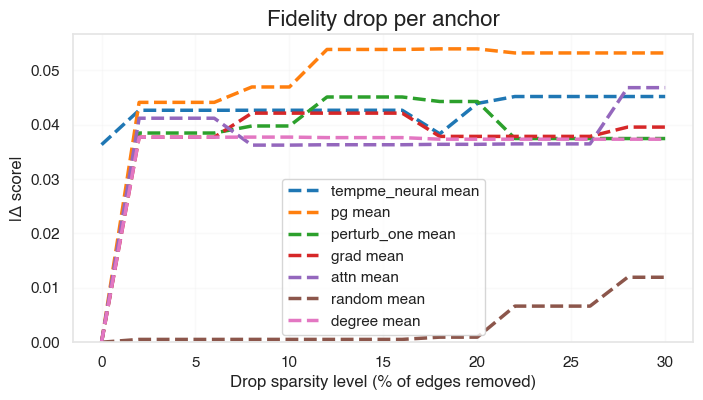

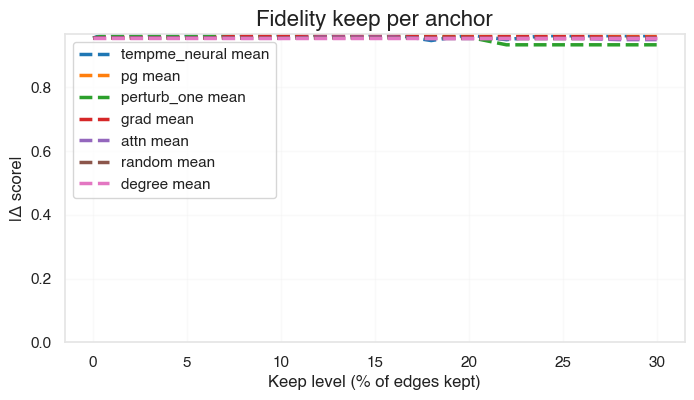

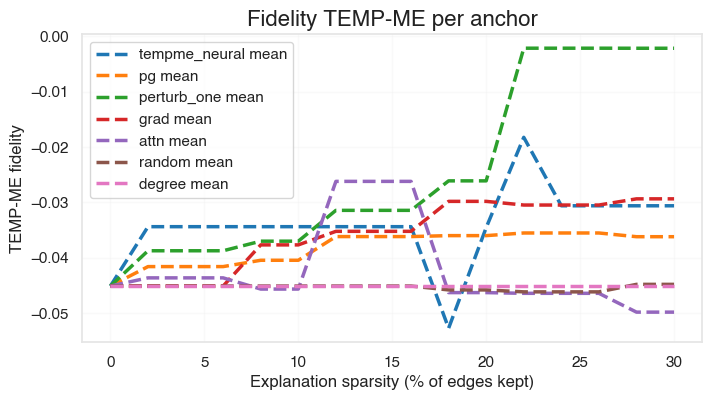

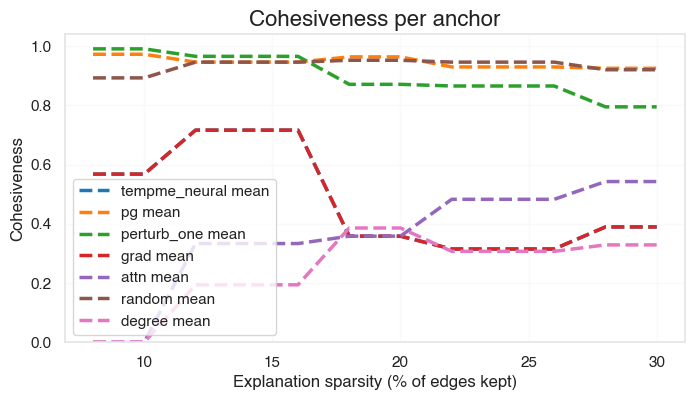

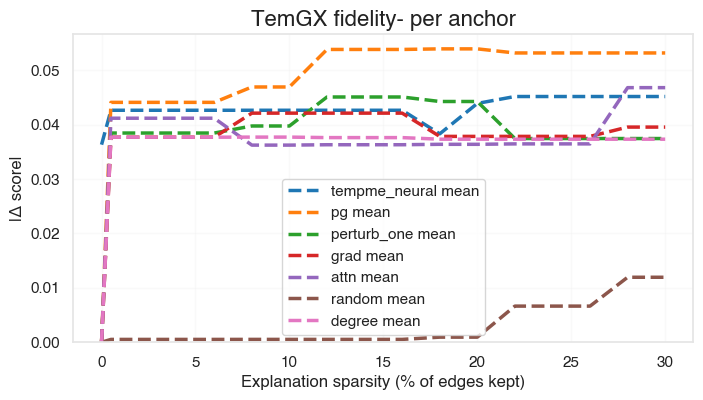

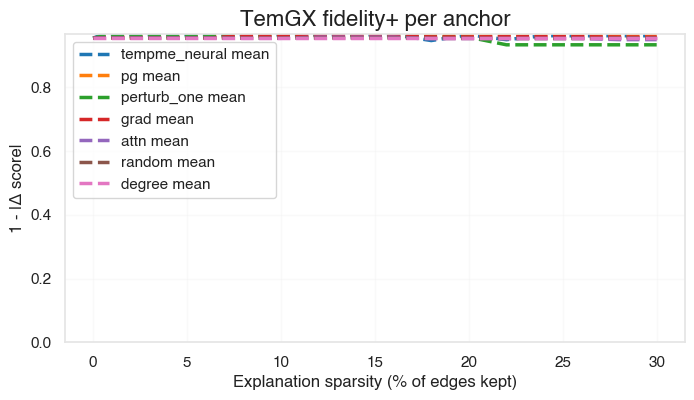

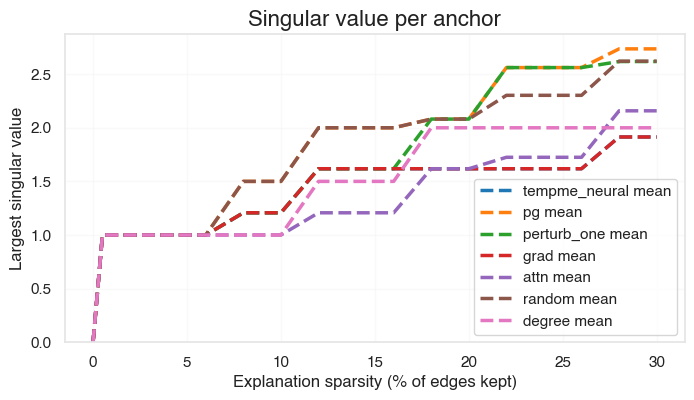


Fidelity drop (prefix=fidelity_drop.@):
  tempme_neural: mean=0.0428, min=0.0045, max=0.0721, n=32
  pg: mean=0.0476, min=0.0000, max=0.0721, n=32
  perturb_one: mean=0.0379, min=0.0000, max=0.0721, n=32
  grad: mean=0.0370, min=0.0000, max=0.0651, n=32
  attn: mean=0.0363, min=0.0000, max=0.0721, n=32
  random: mean=0.0031, min=0.0000, max=0.0229, n=32
  degree: mean=0.0352, min=0.0000, max=0.0651, n=32

Fidelity keep (prefix=fidelity_keep.@):
  tempme_neural: mean=0.9632, min=0.9288, max=0.9994, n=48
  pg: mean=0.9607, min=0.9288, max=0.9971, n=48
  perturb_one: mean=0.9554, min=0.9288, max=0.9947, n=48
  grad: mean=0.9578, min=0.9288, max=0.9993, n=48
  attn: mean=0.9552, min=0.9288, max=0.9842, n=48
  random: mean=0.9547, min=0.9288, max=0.9815, n=48
  degree: mean=0.9549, min=0.9288, max=0.9809, n=48

TEMP-ME fidelity (prefix=fidelity_tempme.@):
  tempme_neural: mean=-0.0343, min=-0.0712, max=0.0317, n=32
  pg: mean=-0.0382, min=-0.0712, max=-0.0029, n=32
  perturb_one: mean=-0.0

In [ ]:
metrics_path = out["csv"]
metrics_df = pd.read_csv(metrics_path)
print(f"Loaded metrics from {metrics_path}")
print(f"Rows: {len(metrics_df)}, Columns: {len(metrics_df.columns)}")

explainer_order = [e.alias for e in EXPLAINERS]
metrics_df, palette = prepare_metrics_plotting(
    metrics_df, explainer_order=explainer_order, cmap_name="tab10"
)

context_cols = [c for c in ("anchor_idx", "explainer", "run_id", "elapsed_sec") if c in metrics_df.columns]

SUMMARY_ONLY = True  # hide per-anchor curves and show only mean lines

curve_results = plot_metric_curves(
    metrics_df, default_curve_specs(), group_col="explainer", palette=palette, show_individual=not SUMMARY_ONLY
)
summarize_curve_results(
    curve_results,
    labels={
        'fidelity_drop.@': 'Fidelity drop',
        'fidelity_keep.@': 'Fidelity keep',
        'fidelity_tempme.@': 'TEMP-ME fidelity',
        'cohesiveness.@': 'Cohesiveness',
        'temgx_fidelity_minus.@': 'TemGX fidelity-',
        'temgx_fidelity_plus.@': 'TemGX fidelity+',
        'singular_value.@': 'Singular value',
    },
)


In [ ]:
# Singular value summary (mean/max across sparsity levels)
sv_cols = [c for c in ("singular_value.mean", "singular_value.max") if c in metrics_df.columns]
if sv_cols and 'explainer' in metrics_df.columns:
    sv_summary = metrics_df.groupby('explainer', dropna=False)[sv_cols].mean().reset_index()
    display(sv_summary.sort_values(by=sv_cols[0], ascending=False))
else:
    print('Singular value metric not found in metrics.csv — rerun with the metric enabled.')


,explainer,singular_value.mean,singular_value.max
1,pg,1.554961,2.736068
5,random,1.513052,2.621320
2,perturb_one,1.472972,2.618034
6,degree,1.312500,2.000000
0,tempme_neural,1.257788,1.914214
3,grad,1.257788,1.914214
4,attn,1.222844,2.158312


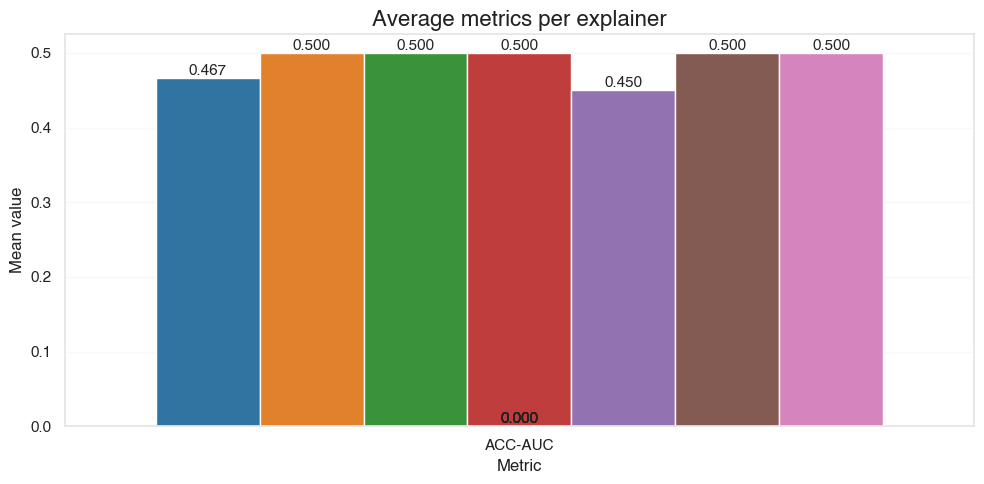

ACC-AUC aggregate (per explainer):


,ACC-AUC
explainer,
tempme_neural,0.466667
pg,0.500000
perturb_one,0.500000
grad,0.500000
attn,0.450000
random,0.500000
degree,0.500000


In [ ]:
if 'acc_auc.auc' in metrics_df.columns and 'explainer' in metrics_df.columns:
    acc_summary = plot_explainer_metric_summary(
        metrics_df,
        metric_columns=[('ACC-AUC', 'acc_auc.auc')],
        agg='mean',
        palette=palette,
        legend=False,
    )
    print('ACC-AUC aggregate (per explainer):')
    display(acc_summary)
else:
    print('ACC-AUC metric not found in metrics.csv — rerun with the metric enabled.')


/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain/visualization/metrics.py:672: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


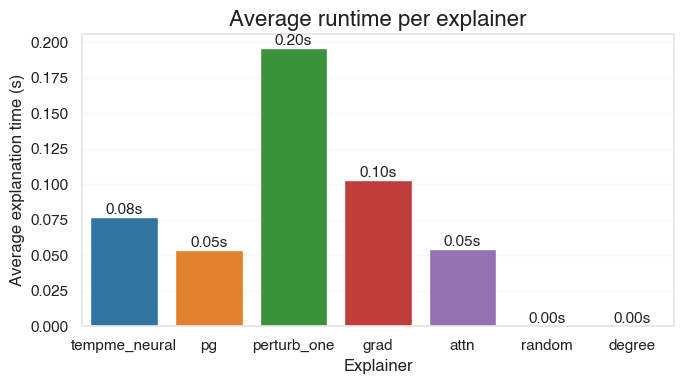

In [ ]:
# Runtime per explainer
_ = plot_explainer_runtime(metrics_df, group_col='explainer', palette=palette)


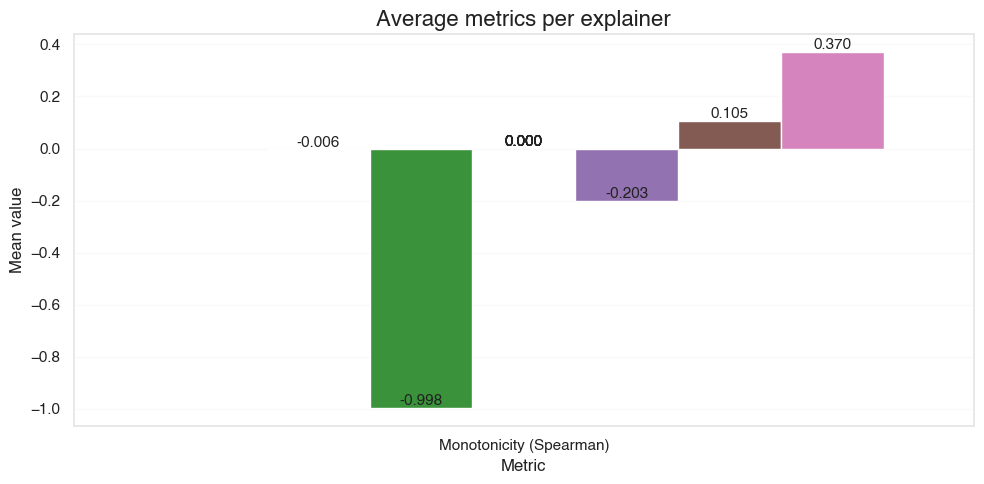

Monotonicity (Spearman rho) aggregate per explainer:


,Monotonicity (Spearman)
explainer,
tempme_neural,NaN
pg,-0.005981
perturb_one,-0.998047
grad,NaN
attn,-0.202551
random,0.105071
degree,0.370309


In [ ]:
# Monotonicity (Spearman rho)
if 'monotonicity.spearman_rho' in metrics_df.columns:
    mono_summary = plot_explainer_metric_summary(
        metrics_df,
        metric_columns=[('Monotonicity (Spearman)', 'monotonicity.spearman_rho')],
        agg='mean',
        palette=palette,
        legend=False,
    )
    print('Monotonicity (Spearman rho) aggregate per explainer:')
    display(mono_summary)
else:
    print('Monotonicity metric not found in metrics.csv — rerun with the metric enabled.')


### Prediction stability vs. sparsity

Percentage of anchors whose masked subgraph keeps the same prediction as the full subgraph, sampled every 0.02 sparsity points (0.00–0.30). The normalized area totals 100% when predictions stay identical across the entire range.


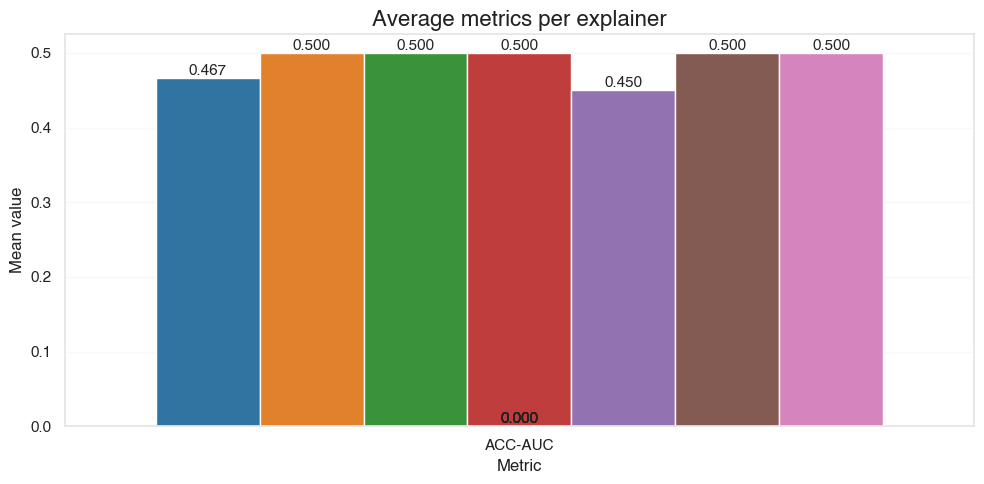

ACC-AUC aggregate (per explainer):


,ACC-AUC
explainer,
tempme_neural,0.466667
pg,0.500000
perturb_one,0.500000
grad,0.500000
attn,0.450000
random,0.500000
degree,0.500000


In [ ]:
if 'acc_auc.auc' in metrics_df.columns and 'explainer' in metrics_df.columns:
    acc_summary = plot_explainer_metric_summary(
        metrics_df,
        metric_columns=[('ACC-AUC', 'acc_auc.auc')],
        agg='mean',
        palette=palette,
        legend=False,
    )
    print('ACC-AUC aggregate (per explainer):')
    display(acc_summary)
else:
    print('ACC-AUC metric not found in metrics.csv — rerun with the metric enabled.')


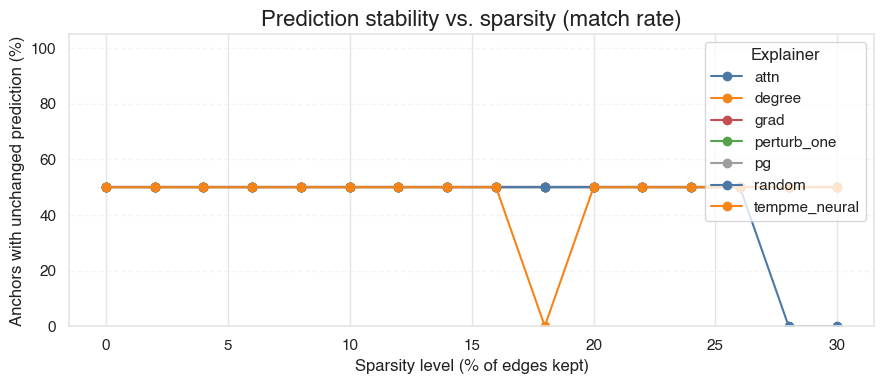

Match rate table (% of anchors with unchanged prediction):


,0%,2%,4%,6%,8%,10%,12%,14%,16%,18%,20%,22%,24%,26%,28%,30%
explainer,,,,,,,,,,,,,,,,
attn,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,0.0
degree,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
grad,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
perturb_one,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
pg,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
random,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
tempme_neural,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,50.0,50.0,50.0,50.0,50.0,50.0



Normalized area under stability curve (100% = perfect stability across the range)


,auc_raw,auc_normalized_percent
explainer,,
attn,0.135,45.000000
degree,0.150,50.000000
grad,0.150,50.000000
perturb_one,0.150,50.000000
pg,0.150,50.000000
random,0.150,50.000000
tempme_neural,0.140,46.666667


In [ ]:
_ = plot_prediction_match_rate(metrics_df, group_col="explainer")


In [ ]:
metric_groups = defaultdict(list)
for col in metrics_df.columns:
    metric_name, sep, remainder = col.partition('.')
    if not sep:
        continue
    metric_groups[metric_name].append(col)

metric_summary = {}
for metric_name, cols in metric_groups.items():
    metric_cols = [c for c in cols if c in metrics_df.columns]
    if not metric_cols:
        continue
    if context_cols:
        agg = metrics_df.groupby(context_cols, dropna=False)[metric_cols].mean().reset_index()
    else:
        agg = pd.DataFrame({metric_name: metrics_df[metric_cols].mean()}).T
    metric_summary[metric_name] = agg
    
def _parse_suffix(token: str):
    if token.startswith('s='):
        try:
            return float(token.split('=', 1)[1])
        except ValueError:
            return token
    try:
        return float(token)
    except ValueError:
        return token

def column_order(col: str):
    _, _, remainder = col.partition('.')
    if remainder == 'prediction_full':
        return (0, 0, 0)
    if remainder.startswith('prediction_') and '.@' in remainder:
        mode_part, _, suffix = remainder.partition('.@')
        suffix_val = _parse_suffix(suffix)
        mode_rank = {'prediction_drop': 0, 'prediction_keep': 1}.get(mode_part, 2)
        return (1, mode_rank, suffix_val)
    if remainder.startswith('@'):
        suffix_val = _parse_suffix(remainder[1:])
        return (2, 0, suffix_val)
    if remainder == 'best':
        return (3, 0, 0)
    if remainder == 'best.k':
        return (3, 1, 0)
    return (4, remainder, 0)

for metric_name in sorted(metric_groups):
    cols = sorted(set(metric_groups[metric_name]), key=column_order)
    shown = context_cols + [c for c in cols if c in metrics_df.columns]
    if len(shown) <= len(context_cols):
        continue
    print(f"=== {metric_name} ===")
    display(metrics_df[shown].sort_values(by=[c for c in shown if c not in context_cols]))
    summary = metric_summary.get(metric_name)
    if summary is not None and not summary.empty:
        print('Average across groups:')
        summary_cols = [c for c in context_cols if c in summary.columns] + [c for c in cols if c in summary.columns]
        display(summary[summary_cols])


=== acc_auc ===


,anchor_idx,explainer,run_id,elapsed_sec,acc_auc.acc@s=0,acc_auc.acc@s=0.02,acc_auc.acc@s=0.04,acc_auc.acc@s=0.06,acc_auc.acc@s=0.08,acc_auc.acc@s=0.1,...,acc_auc.acc@s=0.14,acc_auc.acc@s=0.16,acc_auc.acc@s=0.18,acc_auc.acc@s=0.2,acc_auc.acc@s=0.22,acc_auc.acc@s=0.24,acc_auc.acc@s=0.26,acc_auc.acc@s=0.28,acc_auc.acc@s=0.3,acc_auc.auc
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,1,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.933333
11,1,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.053088,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.900000
8,1,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.047145,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,acc_auc.acc@s=0,acc_auc.acc@s=0.02,acc_auc.acc@s=0.04,acc_auc.acc@s=0.06,acc_auc.acc@s=0.08,acc_auc.acc@s=0.1,...,acc_auc.acc@s=0.14,acc_auc.acc@s=0.16,acc_auc.acc@s=0.18,acc_auc.acc@s=0.2,acc_auc.acc@s=0.22,acc_auc.acc@s=0.24,acc_auc.acc@s=0.26,acc_auc.acc@s=0.28,acc_auc.acc@s=0.3,acc_auc.auc
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== cohesiveness ===


,anchor_idx,explainer,run_id,elapsed_sec,cohesiveness.@s=0.02,cohesiveness.@s=0.04,cohesiveness.@s=0.06,cohesiveness.@s=0.08,cohesiveness.@s=0.1,cohesiveness.@s=0.12,cohesiveness.@s=0.14,cohesiveness.@s=0.16,cohesiveness.@s=0.18,cohesiveness.@s=0.2,cohesiveness.@s=0.22,cohesiveness.@s=0.24,cohesiveness.@s=0.26,cohesiveness.@s=0.28,cohesiveness.@s=0.3
13,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,0.000000,0.000000,0.193894,0.193894,0.193894,0.385906,0.385906,0.306944,0.306944,0.306944,0.328762,0.328762
11,1,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.053088,NaN,NaN,NaN,0.000000,0.000000,0.333287,0.333287,0.333287,0.358265,0.358265,0.482827,0.482827,0.482827,0.542788,0.542788
7,1,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,0.568046,0.568046,0.716530,0.716530,0.716530,0.358265,0.358265,0.314945,0.314945,0.314945,0.389461,0.389461
10,1,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.051580,NaN,NaN,NaN,0.568046,0.568046,0.716530,0.716530,0.716530,0.358265,0.358265,0.314945,0.314945,0.314945,0.389461,0.389461
12,1,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,0.893073,0.893073,0.946292,0.946292,0.946292,0.952634,0.952634,0.946310,0.946310,0.946310,0.920614,0.920614
8,1,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.047145,NaN,NaN,NaN,0.972901,0.972901,0.946292,0.946292,0.946292,0.964045,0.964045,0.930054,0.930054,0.930054,0.925444,0.925444
9,1,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.311417,NaN,NaN,NaN,0.991124,0.991124,0.965851,0.965851,0.965851,0.871313,0.871313,0.865713,0.865713,0.865713,0.795205,0.795205
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,cohesiveness.@s=0.02,cohesiveness.@s=0.04,cohesiveness.@s=0.06,cohesiveness.@s=0.08,cohesiveness.@s=0.1,cohesiveness.@s=0.12,cohesiveness.@s=0.14,cohesiveness.@s=0.16,cohesiveness.@s=0.18,cohesiveness.@s=0.2,cohesiveness.@s=0.22,cohesiveness.@s=0.24,cohesiveness.@s=0.26,cohesiveness.@s=0.28,cohesiveness.@s=0.3
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== fidelity_drop ===


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_drop.prediction_full,fidelity_drop.prediction_drop.@s=0,fidelity_drop.prediction_drop.@s=0.02,fidelity_drop.prediction_drop.@s=0.04,fidelity_drop.prediction_drop.@s=0.06,fidelity_drop.prediction_drop.@s=0.08,...,fidelity_drop.@s=0.12,fidelity_drop.@s=0.14,fidelity_drop.@s=0.16,fidelity_drop.@s=0.18,fidelity_drop.@s=0.2,fidelity_drop.@s=0.22,fidelity_drop.@s=0.24,fidelity_drop.@s=0.26,fidelity_drop.@s=0.28,fidelity_drop.@s=0.3
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,0.436695,0.436695,0.435696,0.435696,0.435696,0.435696,...,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,0.436695,0.436695,0.501818,0.501818,0.501818,0.501818,...,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,0.436695,0.436695,0.501818,0.501818,0.501818,0.501818,...,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,0.436695,0.436695,0.508799,0.508799,0.508799,0.508799,...,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,0.436695,0.436695,0.508799,0.508799,0.508799,0.508799,...,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,0.436695,0.436695,0.508799,0.508799,0.508799,0.508799,...,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,0.436695,0.501764,0.508784,0.508784,0.508784,0.508784,...,0.072089,0.072089,0.072089,0.072089,0.072089,0.072089,0.072089,0.072089,0.072089,0.072089
7,1,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,0.469946,0.462384,0.456757,0.456757,0.456757,0.456757,...,0.013189,0.013189,0.013189,0.004521,0.015701,0.018242,0.018242,0.018242,0.018242,0.018242
8,1,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.047145,0.469946,0.469946,0.453868,0.453868,0.453868,0.448211,...,0.035534,0.035534,0.035534,0.035746,0.035746,0.034243,0.034243,0.034243,0.034243,0.034243
10,1,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.051580,0.469946,0.469946,0.459696,0.459696,0.459696,0.450850,...,0.019096,0.019096,0.019096,0.010547,0.010547,0.010547,0.010547,0.010547,0.013968,0.013968


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_drop.prediction_full,fidelity_drop.prediction_drop.@s=0,fidelity_drop.prediction_drop.@s=0.02,fidelity_drop.prediction_drop.@s=0.04,fidelity_drop.prediction_drop.@s=0.06,fidelity_drop.prediction_drop.@s=0.08,...,fidelity_drop.@s=0.12,fidelity_drop.@s=0.14,fidelity_drop.@s=0.16,fidelity_drop.@s=0.18,fidelity_drop.@s=0.2,fidelity_drop.@s=0.22,fidelity_drop.@s=0.24,fidelity_drop.@s=0.26,fidelity_drop.@s=0.28,fidelity_drop.@s=0.3
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== fidelity_keep ===


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_keep.prediction_full,fidelity_keep.prediction_keep.@s=0,fidelity_keep.prediction_keep.@s=0.005,fidelity_keep.prediction_keep.@s=0.01,fidelity_keep.prediction_keep.@s=0.015,fidelity_keep.prediction_keep.@s=0.02,...,fidelity_keep.@s=0.12,fidelity_keep.@s=0.14,fidelity_keep.@s=0.16,fidelity_keep.@s=0.18,fidelity_keep.@s=0.2,fidelity_keep.@s=0.22,fidelity_keep.@s=0.24,fidelity_keep.@s=0.26,fidelity_keep.@s=0.28,fidelity_keep.@s=0.3
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,0.436695,0.507876,0.504920,0.504920,0.504920,0.504920,...,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,0.436695,0.507876,0.504920,0.504920,0.504920,0.504920,...,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,0.436695,0.507876,0.504920,0.504920,0.504920,0.504920,...,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,0.436695,0.507876,0.504920,0.504920,0.504920,0.504920,...,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,0.436695,0.507876,0.507876,0.507876,0.507876,0.507876,...,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,0.436695,0.507876,0.507876,0.507876,0.507876,0.507876,...,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,0.436695,0.507876,0.507876,0.507876,0.507876,0.507876,...,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819
7,1,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,0.469946,0.489037,0.470529,0.470529,0.470529,0.470529,...,0.999417,0.999417,0.999417,0.962709,0.999081,0.968281,0.993028,0.993028,0.993028,0.993028
9,1,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.311417,0.469946,0.489037,0.479237,0.479237,0.479237,0.479237,...,0.994679,0.994679,0.994679,0.984016,0.984016,0.936053,0.936053,0.936053,0.936071,0.936071
8,1,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.047145,0.469946,0.489037,0.484961,0.484961,0.484961,0.484961,...,0.995839,0.995839,0.995839,0.996183,0.996183,0.997138,0.997138,0.997138,0.995792,0.995792


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_keep.prediction_full,fidelity_keep.prediction_keep.@s=0,fidelity_keep.prediction_keep.@s=0.005,fidelity_keep.prediction_keep.@s=0.01,fidelity_keep.prediction_keep.@s=0.015,fidelity_keep.prediction_keep.@s=0.02,...,fidelity_keep.@s=0.12,fidelity_keep.@s=0.14,fidelity_keep.@s=0.16,fidelity_keep.@s=0.18,fidelity_keep.@s=0.2,fidelity_keep.@s=0.22,fidelity_keep.@s=0.24,fidelity_keep.@s=0.26,fidelity_keep.@s=0.28,fidelity_keep.@s=0.3
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== fidelity_tempme ===


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_tempme.@s=0,fidelity_tempme.@s=0.02,fidelity_tempme.@s=0.04,fidelity_tempme.@s=0.06,fidelity_tempme.@s=0.08,fidelity_tempme.@s=0.1,fidelity_tempme.@s=0.12,fidelity_tempme.@s=0.14,fidelity_tempme.@s=0.16,fidelity_tempme.@s=0.18,fidelity_tempme.@s=0.2,fidelity_tempme.@s=0.22,fidelity_tempme.@s=0.24,fidelity_tempme.@s=0.26,fidelity_tempme.@s=0.28,fidelity_tempme.@s=0.3
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181,-0.071181
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,-0.071181,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,-0.071181,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,-0.071181,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,-0.071181,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225,-0.068225
11,1,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.053088,-0.019091,-0.019091,-0.019091,-0.019091,-0.023142,-0.023142,0.015795,0.015795,0.015795,-0.024421,-0.024421,-0.024680,-0.024680,-0.024680,-0.031482,-0.031482
12,1,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.020493,-0.020493,-0.021195,-0.021195,-0.021195,-0.018483,-0.018483
13,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091,-0.019091


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_tempme.@s=0,fidelity_tempme.@s=0.02,fidelity_tempme.@s=0.04,fidelity_tempme.@s=0.06,fidelity_tempme.@s=0.08,fidelity_tempme.@s=0.1,fidelity_tempme.@s=0.12,fidelity_tempme.@s=0.14,fidelity_tempme.@s=0.16,fidelity_tempme.@s=0.18,fidelity_tempme.@s=0.2,fidelity_tempme.@s=0.22,fidelity_tempme.@s=0.24,fidelity_tempme.@s=0.26,fidelity_tempme.@s=0.28,fidelity_tempme.@s=0.3
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== monotonicity ===


,anchor_idx,explainer,run_id,elapsed_sec,monotonicity.spearman_rho
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,-1.000000
9,1,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.311417,-0.996094
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,-0.800000
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,-0.632456
12,1,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,-0.189857
13,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,0.010322
11,1,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.053088,0.227354
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,0.400000
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,0.730297
8,1,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.047145,0.788037


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,monotonicity.spearman_rho
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN
...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN


=== prediction_profile ===


,anchor_idx,explainer,run_id,elapsed_sec,prediction_profile.prediction_full,prediction_profile.prediction_keep.@s=0,prediction_profile.prediction_keep.@s=0.02,prediction_profile.prediction_keep.@s=0.04,prediction_profile.prediction_keep.@s=0.06,prediction_profile.prediction_keep.@s=0.08,...,prediction_profile.match_keep.@s=0.12,prediction_profile.match_keep.@s=0.14,prediction_profile.match_keep.@s=0.16,prediction_profile.match_keep.@s=0.18,prediction_profile.match_keep.@s=0.2,prediction_profile.match_keep.@s=0.22,prediction_profile.match_keep.@s=0.24,prediction_profile.match_keep.@s=0.26,prediction_profile.match_keep.@s=0.28,prediction_profile.match_keep.@s=0.3
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,0.436695,0.507876,0.504920,0.504920,0.504920,0.504920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,0.436695,0.507876,0.504920,0.504920,0.504920,0.504920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,0.436695,0.507876,0.504920,0.504920,0.504920,0.504920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,0.436695,0.507876,0.504920,0.504920,0.504920,0.504920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,0.436695,0.507876,0.507876,0.507876,0.507876,0.507876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,0.436695,0.507876,0.507876,0.507876,0.507876,0.507876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,0.436695,0.507876,0.507876,0.507876,0.507876,0.507876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,0.469946,0.489037,0.470529,0.470529,0.470529,0.470529,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.311417,0.469946,0.489037,0.479237,0.479237,0.479237,0.475770,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.047145,0.469946,0.489037,0.484961,0.484961,0.484961,0.482675,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,prediction_profile.prediction_full,prediction_profile.prediction_keep.@s=0,prediction_profile.prediction_keep.@s=0.02,prediction_profile.prediction_keep.@s=0.04,prediction_profile.prediction_keep.@s=0.06,prediction_profile.prediction_keep.@s=0.08,...,prediction_profile.match_keep.@s=0.12,prediction_profile.match_keep.@s=0.14,prediction_profile.match_keep.@s=0.16,prediction_profile.match_keep.@s=0.18,prediction_profile.match_keep.@s=0.2,prediction_profile.match_keep.@s=0.22,prediction_profile.match_keep.@s=0.24,prediction_profile.match_keep.@s=0.26,prediction_profile.match_keep.@s=0.28,prediction_profile.match_keep.@s=0.3
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== singular_value ===


,anchor_idx,explainer,run_id,elapsed_sec,singular_value.@s=0,singular_value.@s=0.005,singular_value.@s=0.01,singular_value.@s=0.015,singular_value.@s=0.02,singular_value.@s=0.025,...,singular_value.@s=0.16,singular_value.@s=0.18,singular_value.@s=0.2,singular_value.@s=0.22,singular_value.@s=0.24,singular_value.@s=0.26,singular_value.@s=0.28,singular_value.@s=0.3,singular_value.max,singular_value.mean
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.958333
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.958333
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.958333
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.958333
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.958333
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.958333
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.958333
11,1,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.053088,0.0,1.0,1.0,1.0,1.0,1.0,...,1.414214,2.236068,2.236068,2.449490,2.449490,2.449490,3.316625,3.316625,3.316625,1.487354
13,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,0.0,1.0,1.0,1.0,1.0,1.0,...,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.666667
7,1,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,0.0,1.0,1.0,1.0,1.0,1.0,...,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.828427,2.828427,2.828427,1.557243


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,singular_value.@s=0,singular_value.@s=0.005,singular_value.@s=0.01,singular_value.@s=0.015,singular_value.@s=0.02,singular_value.@s=0.025,...,singular_value.@s=0.16,singular_value.@s=0.18,singular_value.@s=0.2,singular_value.@s=0.22,singular_value.@s=0.24,singular_value.@s=0.26,singular_value.@s=0.28,singular_value.@s=0.3,singular_value.max,singular_value.mean
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== sparsity ===


,anchor_idx,explainer,run_id,elapsed_sec,sparsity.edges.density,sparsity.edges.entropy,sparsity.edges.gini,sparsity.edges.l0,sparsity.edges.mean,sparsity.edges.n,sparsity.edges.std,sparsity.edges.zero_frac,sparsity.nodes.l0,sparsity.nodes.n
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,0.0,0.000000,0.000000,4,0.000000,4,0.000000,1.0,0,0
10,1,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.051580,0.0,0.000000,0.000000,21,0.000000,21,0.000000,1.0,0,0
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,0.0,0.000000,0.000000,80,0.000000,80,0.000000,1.0,0,0
7,1,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,0.0,0.000000,0.000000,80,0.000000,80,0.000000,1.0,0,0
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,1.0,0.981135,0.211428,0,0.380058,4,0.317698,0.0,0,0
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,1.0,1.121365,0.030550,0,0.195255,4,0.116787,0.0,0,0
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,1.0,1.135443,0.089286,0,0.525000,4,0.335876,0.0,0,0
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,1.0,1.364148,-0.145161,0,62.000000,4,13.000000,0.0,0,0
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,1.0,1.367276,-0.142528,0,0.235902,4,0.046068,0.0,0,0
9,1,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.311417,1.0,2.362861,0.568529,0,-0.012292,21,0.026181,0.0,0,0


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,sparsity.edges.density,sparsity.edges.entropy,sparsity.edges.gini,sparsity.edges.l0,sparsity.edges.mean,sparsity.edges.n,sparsity.edges.std,sparsity.edges.zero_frac,sparsity.nodes.l0,sparsity.nodes.n
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== subgraphx_mcts ===


,anchor_idx,explainer,run_id,elapsed_sec,subgraphx_mcts.@s=0,subgraphx_mcts.@s=0.05,subgraphx_mcts.@s=0.1,subgraphx_mcts.@s=0.15,subgraphx_mcts.@s=0.2,subgraphx_mcts.@s=0.25,...,subgraphx_mcts.@s=0.55,subgraphx_mcts.@s=0.6,subgraphx_mcts.@s=0.65,subgraphx_mcts.@s=0.7,subgraphx_mcts.@s=0.75,subgraphx_mcts.@s=0.8,subgraphx_mcts.@s=0.85,subgraphx_mcts.@s=0.9,subgraphx_mcts.@s=0.95,subgraphx_mcts.@s=1
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.047145,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.311417,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,subgraphx_mcts.@s=0,subgraphx_mcts.@s=0.05,subgraphx_mcts.@s=0.1,subgraphx_mcts.@s=0.15,subgraphx_mcts.@s=0.2,subgraphx_mcts.@s=0.25,...,subgraphx_mcts.@s=0.55,subgraphx_mcts.@s=0.6,subgraphx_mcts.@s=0.65,subgraphx_mcts.@s=0.7,subgraphx_mcts.@s=0.75,subgraphx_mcts.@s=0.8,subgraphx_mcts.@s=0.85,subgraphx_mcts.@s=0.9,subgraphx_mcts.@s=0.95,subgraphx_mcts.@s=1
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== temgx_fidelity_minus ===


,anchor_idx,explainer,run_id,elapsed_sec,temgx_fidelity_minus.prediction_full,temgx_fidelity_minus.@s=0,temgx_fidelity_minus.@s=0.005,temgx_fidelity_minus.@s=0.01,temgx_fidelity_minus.@s=0.015,temgx_fidelity_minus.@s=0.02,...,temgx_fidelity_minus.@s=0.14,temgx_fidelity_minus.@s=0.16,temgx_fidelity_minus.@s=0.18,temgx_fidelity_minus.@s=0.2,temgx_fidelity_minus.@s=0.22,temgx_fidelity_minus.@s=0.24,temgx_fidelity_minus.@s=0.26,temgx_fidelity_minus.@s=0.28,temgx_fidelity_minus.@s=0.3,temgx_fidelity_minus.aufsc
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,0.436695,0.000000,0.000999,0.000999,0.000999,0.000999,...,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.000125
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,0.436695,0.000000,0.065123,0.065123,0.065123,0.065123,...,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.008140
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,0.436695,0.000000,0.065123,0.065123,0.065123,0.065123,...,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.065123,0.008140
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,0.436695,0.000000,0.072104,0.072104,0.072104,0.072104,...,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.009013
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,0.436695,0.000000,0.072104,0.072104,0.072104,0.072104,...,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.009013
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,0.436695,0.000000,0.072104,0.072104,0.072104,0.072104,...,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.072104,0.009013
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,0.436695,0.065069,0.072089,0.072089,0.072089,0.072089,...,0.072089,0.072089,0.072089,0.072089,0.072089,0.072089,0.072089,0.072089,0.072089,0.021583
12,1,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,0.469946,0.000000,0.000027,0.000027,0.000027,0.000027,...,0.000036,0.000036,0.000859,0.000859,0.012271,0.012271,0.012271,0.022876,0.022876,0.001175
9,1,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.311417,0.469946,0.000000,0.004802,0.004802,0.004802,0.004802,...,0.018053,0.018053,0.016395,0.016395,0.002779,0.002779,0.002779,0.002779,0.002779,0.002420
11,1,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.053088,0.469946,0.000000,0.010250,0.010250,0.010250,0.010250,...,0.000500,0.000500,0.000655,0.000655,0.000812,0.000812,0.000812,0.021487,0.021487,0.001110


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,temgx_fidelity_minus.prediction_full,temgx_fidelity_minus.@s=0,temgx_fidelity_minus.@s=0.005,temgx_fidelity_minus.@s=0.01,temgx_fidelity_minus.@s=0.015,temgx_fidelity_minus.@s=0.02,...,temgx_fidelity_minus.@s=0.14,temgx_fidelity_minus.@s=0.16,temgx_fidelity_minus.@s=0.18,temgx_fidelity_minus.@s=0.2,temgx_fidelity_minus.@s=0.22,temgx_fidelity_minus.@s=0.24,temgx_fidelity_minus.@s=0.26,temgx_fidelity_minus.@s=0.28,temgx_fidelity_minus.@s=0.3,temgx_fidelity_minus.aufsc
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== temgx_fidelity_plus ===


,anchor_idx,explainer,run_id,elapsed_sec,temgx_fidelity_plus.prediction_full,temgx_fidelity_plus.@s=0,temgx_fidelity_plus.@s=0.005,temgx_fidelity_plus.@s=0.01,temgx_fidelity_plus.@s=0.015,temgx_fidelity_plus.@s=0.02,...,temgx_fidelity_plus.@s=0.14,temgx_fidelity_plus.@s=0.16,temgx_fidelity_plus.@s=0.18,temgx_fidelity_plus.@s=0.2,temgx_fidelity_plus.@s=0.22,temgx_fidelity_plus.@s=0.24,temgx_fidelity_plus.@s=0.26,temgx_fidelity_plus.@s=0.28,temgx_fidelity_plus.@s=0.3,temgx_fidelity_plus.aufsc
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,0.436695,0.928819,0.928819,0.928819,0.928819,0.928819,...,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.232205
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,0.436695,0.928819,0.928819,0.928819,0.928819,0.928819,...,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.232205
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,0.436695,0.928819,0.928819,0.928819,0.928819,0.928819,...,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.928819,0.232205
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,0.436695,0.928819,0.931775,0.931775,0.931775,0.931775,...,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.232574
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,0.436695,0.928819,0.931775,0.931775,0.931775,0.931775,...,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.232574
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,0.436695,0.928819,0.931775,0.931775,0.931775,0.931775,...,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.232574
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,0.436695,0.928819,0.931775,0.931775,0.931775,0.931775,...,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.931775,0.279514
11,1,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.053088,0.469946,0.980909,0.980909,0.980909,0.980909,0.980909,...,0.984205,0.984205,0.975579,0.975579,0.975320,0.975320,0.975320,0.968518,0.968518,0.279409
12,1,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,0.469946,0.980909,0.980909,0.980909,0.980909,0.980909,...,0.980909,0.980909,0.979507,0.979507,0.978805,0.978805,0.978805,0.981517,0.981517,0.280107
13,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,0.469946,0.980909,0.980909,0.980909,0.980909,0.980909,...,0.980909,0.980909,0.980909,0.980909,0.980909,0.980909,0.980909,0.980909,0.980909,0.280260


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,temgx_fidelity_plus.prediction_full,temgx_fidelity_plus.@s=0,temgx_fidelity_plus.@s=0.005,temgx_fidelity_plus.@s=0.01,temgx_fidelity_plus.@s=0.015,temgx_fidelity_plus.@s=0.02,...,temgx_fidelity_plus.@s=0.14,temgx_fidelity_plus.@s=0.16,temgx_fidelity_plus.@s=0.18,temgx_fidelity_plus.@s=0.2,temgx_fidelity_plus.@s=0.22,temgx_fidelity_plus.@s=0.24,temgx_fidelity_plus.@s=0.26,temgx_fidelity_plus.@s=0.28,temgx_fidelity_plus.@s=0.3,temgx_fidelity_plus.aufsc
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== temgx_sparsity ===


,anchor_idx,explainer,run_id,elapsed_sec,temgx_sparsity.ratio
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN
1,0,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN
2,0,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN
3,0,grad,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN
4,0,attn,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.056066,NaN
5,0,random,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN
6,0,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN
7,1,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN
8,1,pg,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.047145,NaN
9,1,perturb_one,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.311417,NaN


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,temgx_sparsity.ratio
0,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000037,NaN
1,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000064,NaN
2,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000226,NaN
3,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.000715,NaN
4,0,tempme_neural,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.019905,NaN
...,...,...,...,...,...
191,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.059571,NaN
192,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.080060,NaN
193,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.134107,NaN
194,1,degree,stick_figure_tgn_tempme_neural-pg-perturb_one-...,0.154633,NaN


In [ ]:
if metrics_df.empty:
    raise RuntimeError("metrics_df is empty; nothing to evaluate.")

fidelity_cols = [c for c in metrics_df.columns if c.startswith("fidelity_")]
sparsity_cols = [c for c in metrics_df.columns if "sparsity" in c]

summary = {}

# Fidelity checks
fid_arrays = []
for col in fidelity_cols:
    vals = metrics_df[col].to_numpy(dtype=float)
    finite = vals[np.isfinite(vals)]
    if finite.size == 0:
        raise RuntimeError(f"{col} has no finite values (all NaN/inf).")
    fid_arrays.append(finite)
    frac_nan = 1.0 - (finite.size / max(1, vals.size))
    if frac_nan > 0:
        print(f"⚠️  {col}: {frac_nan:.1%} of values were NaN and were dropped from sanity checks.")

if fid_arrays:
    all_fid = np.concatenate(fid_arrays)
    summary["fidelity"] = {
        "mean": float(all_fid.mean()),
        "std": float(all_fid.std()),
        "min": float(all_fid.min()),
        "max": float(all_fid.max()),
    }
else:
    print("No fidelity_* columns present; skipping fidelity sanity checks.")

# Sparsity checks (should live in [0, 1])
ratio_suffixes = (".zero_frac", ".density")
count_suffixes = (".n", ".l0")

for col in sparsity_cols:
    vals = metrics_df[col].to_numpy(dtype=float)
    finite_mask = np.isfinite(vals)
    finite = vals[finite_mask]
    if finite.size == 0:
        print(f"⚠️  {col}: all values are NaN/inf; skipping.")
        continue
    suffix = next((s for s in ratio_suffixes + count_suffixes if col.endswith(s)), None)
    if suffix in count_suffixes:
        if (finite < -1e-6).any():
            raise RuntimeError(f"{col} contains negative counts: min={finite.min():.3f}")
        summary.setdefault("sparsity_counts", {})[col] = float(finite.mean())
        continue
    if suffix in ratio_suffixes:
        if (finite < -1e-6).any() or (finite > 1 + 1e-6).any():
            raise RuntimeError(
                f"{col} contains values outside [0, 1]: min={finite.min():.3f}, max={finite.max():.3f}"
            )
        summary.setdefault("sparsity", {})[col] = float(finite.mean())
        continue
    summary.setdefault("sparsity_misc", {})[col] = float(finite.mean())
    missing_frac = 1.0 - (finite.size / max(1, vals.size))
    if missing_frac > 0:
        print(f"⚠️  {col}: skipped {missing_frac:.1%} missing values.")

# Monotonicity checks for fidelity series (per row)
trend_expectations = {
    "fidelity_drop": ("non_decreasing", "Removing more edges should not reduce the drop in score."),
    "fidelity_keep": ("non_decreasing", "Keeping more edges should not reduce coverage (expect absolute change grows)."),
}
pattern = re.compile(r"^(fidelity_(?:drop|keep))\.@(.*)")
violations = []

for prefix, (expect, desc) in trend_expectations.items():
    prefix_cols = [c for c in fidelity_cols if c.startswith(prefix + ".@")]
    if not prefix_cols:
        continue
    # sort columns by sparsity level
    col_info = []
    for col in prefix_cols:
        m = pattern.match(col)
        if not m:
            continue
        level = m.group(2)
        try:
            level_val = float(level.split('=')[1]) if level.startswith('s=') else float(level)
        except ValueError:
            continue
        col_info.append((level_val, col))
    col_info.sort()
    if not col_info:
        continue

    for row_idx in metrics_df.index:
        values = []
        for lvl, col in col_info:
            val = metrics_df.at[row_idx, col]
            if val is None:
                continue
            try:
                val_f = float(val)
            except (TypeError, ValueError):
                continue
            if not np.isfinite(val_f):
                continue
            values.append((lvl, val_f))
        if len(values) < 2:
            continue
        values.sort()
        seq = np.array([v for _, v in values], dtype=float)
        diffs = np.diff(seq)
        tol = 1e-6
        if expect == "non_decreasing" and np.any(diffs < -tol):
            violations.append((prefix, row_idx, [lvl for lvl, _ in values], seq.tolist(), desc))

if violations:
    lines = ["Fidelity monotonicity check failed for the following rows:"]
    for prefix, row_idx, lvls, seq, desc in violations[:5]:
        anchor = metrics_df.at[row_idx, "anchor_idx"] if "anchor_idx" in metrics_df.columns else row_idx
        expl = metrics_df.at[row_idx, "explainer"] if "explainer" in metrics_df.columns else "?"
        lines.append(
            f"  [{prefix}] row={row_idx} (anchor={anchor}, explainer={expl}): levels={lvls} values={seq} :: {desc}"
        )
    print("\n".join(lines))


⚠️  temgx_sparsity.ratio: all values are NaN/inf; skipping.
Fidelity monotonicity check failed for the following rows:
  [fidelity_drop] row=7 (anchor=1, explainer=tempme_neural): levels=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3] values=[0.0075624783449156, 0.0131892049322842, 0.0131892049322842, 0.0131892049322842, 0.0131892049322842, 0.0131892049322842, 0.0131892049322842, 0.0131892049322842, 0.0131892049322842, 0.0045214244459632, 0.0157013299986833, 0.018242005220859, 0.018242005220859, 0.018242005220859, 0.018242005220859, 0.018242005220859] :: Removing more edges should not reduce the drop in score.
  [fidelity_drop] row=8 (anchor=1, explainer=pg): levels=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3] values=[0.0, 0.0160779355887204, 0.0160779355887204, 0.0160779355887204, 0.0217345375712501, 0.0217345375712501, 0.0355337408046124, 0.0355337408046124, 0.0355337408046124, 0.035745653079

In [ ]:
print("Metric sanity summary:")
for key, val in summary.items():
    print(f"  {key}: {val}")

Metric sanity summary:
  fidelity: {'mean': 0.441893401266763, 'std': 0.36248709736717344, 'min': -0.0711810068440627, 'max': 0.9994167192268646}
  sparsity_counts: {'sparsity.edges.n': 22.142857142857142, 'sparsity.edges.l0': 13.214285714285714, 'sparsity.nodes.n': 0.0, 'sparsity.nodes.l0': 0.0}
  sparsity: {'sparsity.edges.zero_frac': 0.2857142857142857, 'sparsity.edges.density': 0.7142857142857143}
  sparsity_misc: {'sparsity.edges.gini': 0.08817561572874726, 'sparsity.edges.entropy': 1.4419434306537082, 'sparsity.edges.mean': 8.93480308223636, 'sparsity.edges.std': 1.9917403867945105}
